# Import

In [15]:
import os
import torch
import pytorch_lightning as pl
from time import time_ns
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from rnaquanet.network.graph_regression_network import GraphRegressionNetwork
from rnaquanet.network.grn_data_module import GRNDataModule
from rnaquanet.utils.rnaquanet_config import RnaquanetConfig
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from torch.optim import Adam
from torch.nn import (
    BatchNorm1d,
    Identity,
    ReLU,
    LeakyReLU,
    Linear,
    MSELoss
)
import torch.nn.functional as F
from torch_geometric.nn import (
    GATConv,
    GCNConv,
    Sequential,
    global_mean_pool,
    BatchNorm,
    TransformerConv
)
from torch_geometric.nn.models import (
    GAT
)
from torch_geometric.loader import DataLoader
import numpy as np
from rnaquanet.data.preprocessing.hdf5_utils import load_data_from_hdf5
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from rnaquanet.network.h5_graph_dataset import H5GraphDataset
import math

In [16]:
ares_train_data = H5GraphDataset('/app/data/ares/train.h5').__enter__()

seg1_val_data = H5GraphDataset('/app/data/segments_1_coords/val.h5').__enter__()
seg1_test_data = H5GraphDataset('/app/data/segments_1_coords/test.h5').__enter__()

seg2_val_data = H5GraphDataset('/app/data/segments_2_coords/val.h5').__enter__()
seg2_test_data = H5GraphDataset('/app/data/segments_2_coords/test.h5').__enter__()

seg3_val_data = H5GraphDataset('/app/data/segments_3_coords/val.h5').__enter__()
seg3_test_data = H5GraphDataset('/app/data/segments_3_coords/test.h5').__enter__()

ares_val_data = H5GraphDataset('/app/data/ares/val.h5').__enter__()
ares_test_data = H5GraphDataset('/app/data/ares/test.h5').__enter__()

dataset = 'ares'

In [17]:
def plot_loss_chart(losses, epoch):
    bars = len(losses.values()) # num of bars
    epochs = range(1, epoch+2)
    width = 1.0/bars * 0.75
    multiplier = 0
    _, ax = plt.subplots(layout='constrained')

    for key, value in losses.items():
        x = np.arange(len(value['losses']))

        loss_values = value['losses']
        offset = width * multiplier
        rects = ax.bar(x + offset, loss_values, width, label=key, color=value['color'], alpha=0.5)
        ax.bar_label(rects, fmt='%0.0f', padding=3)
        ax.plot(x+((bars-1)/2)*width, loss_values, color=value['color'], alpha=0.5)
        multiplier += 1

    x = np.arange(len(epochs))
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(x + ((bars-1)/2)*width, epochs)
    ax.legend()
    plt.savefig(os.path.join('train', f'{dataset}.png'))
    plt.show()


def get_desc(epoch, losses):
    desc = f'Epoch {epoch+1}\n'
    for key, value in losses.items():
        if value['losses']:
            desc += f'Prev {key} {value["losses"][-1]:.2f}\tBest {key} {np.min(value["losses"]):.2f}\n'
    return desc.rstrip('\n')

def process_epoch(
        epoch, 
        batch_size, 
        device, 
        model,
        loss_fn,
        mse_no_reduce,
        optimizer,
        patience, 
        
        losses, key,
        best_model, best_loss,

        save_values = False,
        plot = True
    ):
    step = []
    values = {'predicted': [], 'true': []}
    assert(not losses[key]['train'] or not save_values)

    if losses[key]['data'].max_iterations != None:
        losses[key]['data'].shuffle()
    

    with tqdm(total=len(losses[key]['data']), desc=f'{key.capitalize()} epoch {epoch+1}', position=0, leave=True) as progressbar:
        if not losses[key]['train']:
            with torch.no_grad():
                for item in DataLoader(losses[key]['data'], batch_size=batch_size, shuffle=False, num_workers=4):
                    item = item.to(device)
                    y_pred = model(x=item.x, edge_index=item.edge_index, edge_attr=item.edge_attr, batch=item.batch).view(-1)
                    step.extend(mse_no_reduce(y_pred, item.y).cpu().tolist())
                    if save_values:
                        values['predicted'].extend(y_pred.cpu().tolist())
                        values['true'].extend(item.y.view(-1).cpu().tolist())
                    progressbar.update(item.y.cpu().shape[0])
        else:
            for item in DataLoader(losses[key]['data'], batch_size=batch_size, shuffle=(losses[key]['data'].max_iterations == None), num_workers=4):
                item = item.to(device)
                y_pred = model(x=item.x, edge_index=item.edge_index, edge_attr=item.edge_attr, batch=item.batch).view(-1)
                loss = loss_fn(y_pred, item.y)
                step.extend(mse_no_reduce(y_pred, item.y).cpu().tolist())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                progressbar.update(item.y.cpu().shape[0])
        
    losses[key]['losses'].append(np.mean(step))
    if save_values:
        losses[key]['values'].append(values)
    clear_output(wait=True)
    print(get_desc(epoch, losses))
    if plot:
        plot_loss_chart(losses, epoch)

    index = np.argmin(losses[key]['losses'])
    if losses[key]['patience']:
        if losses[key]['losses'][-1] < best_loss:
            return model.state_dict().copy(), losses[key]['losses'][index], False
    return best_model, best_loss, losses[key]['patience'] and index <= (epoch-patience)

Epoch 12
Prev ares train 2.75	Best ares train 2.51
Prev ares val 6.95	Best ares val 6.58


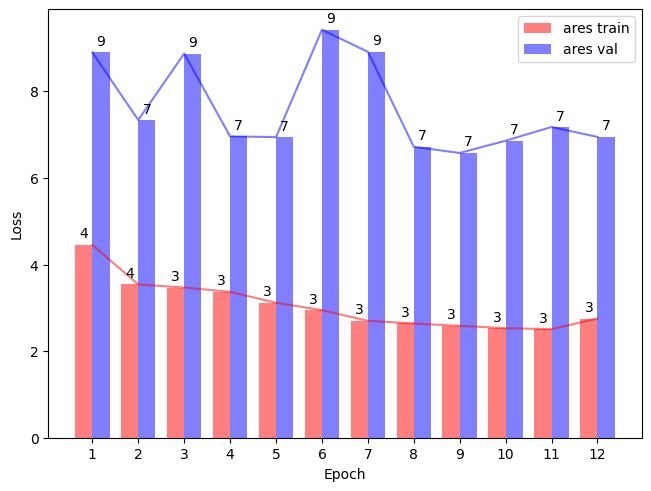

In [18]:
torch.set_float32_matmul_precision('high')
torch.manual_seed(2137)
device = torch.device('cuda:0')

max_epochs = 1000
batch_size = 32
patience = 3

model = Sequential('x, edge_index, edge_attr, batch', [
    (GATConv(in_channels=99, out_channels=256, heads=4, dropout=0.5), 'x, edge_index, edge_attr -> x'),
    (BatchNorm(in_channels=256*4), 'x -> x'),
    (ReLU(), 'x -> x'),
    (GATConv(in_channels=256*4, out_channels=256, heads=8, dropout=0.5), 'x, edge_index, edge_attr -> x'),
    (BatchNorm(in_channels=256*8), 'x -> x'),
    (ReLU(), 'x -> x'),

    (GCNConv(in_channels=256*8, out_channels=256), 'x, edge_index -> x'),
    (global_mean_pool, 'x, batch -> x'),

    (Linear(in_features=256, out_features=64), 'x -> x'),
    (ReLU(), 'x -> x'),
    (Linear(in_features=64, out_features=1), 'x -> x'),
]).to(device)

loss_fn = MSELoss(reduction='mean').to(device)
mse_no_reduce = MSELoss(reduction='none').to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

losses = {
    'ares train': {
        'data': ares_train_data,
        'losses': [],
        'color': 'red',
        'train': True,
        'patience': False
    },
    'ares val': {
        'data': ares_val_data,
        'losses': [],
        'color': 'blue',
        'train': False,
        'patience': True,
        'values': []
    },
}

best_model = None
best_loss = float('inf')

for epoch in range(max_epochs):
    for key in losses.keys():
        best_model, best_loss, cond = process_epoch(epoch, batch_size, device, model, loss_fn, mse_no_reduce, optimizer, patience, losses, key, best_model, best_loss)
        if cond:
            break
    else:
        continue
    break

torch.save(best_model, os.path.join('model', f'{dataset}.pt'))

In [19]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [20]:

with torch.no_grad():
    n = 0
    print(f'predicted\tground truth\tdiff')
    for item in DataLoader(losses['ares val']['data'], batch_size=1, shuffle=True, num_workers=4):
        item = item.to(device)
        y_pred = model(x=item.x, edge_index=item.edge_index, edge_attr=item.edge_attr, batch=item.batch).view(-1)
        print(f'{y_pred.cpu().item()}\t{item.y.cpu().item()}\t{y_pred.cpu().item()-item.y.cpu().item()}')
        n += 1
        if n == 10:
            break

predicted	ground truth	diff
7.241978645324707	6.171000003814697	1.0709786415100098
7.158518314361572	9.920999526977539	-2.762481212615967
7.286677837371826	2.9200000762939453	4.366677761077881
6.7762064933776855	4.550000190734863	2.2262063026428223
7.098789691925049	8.413000106811523	-1.3142104148864746
7.402916431427002	4.021999835968018	3.3809165954589844
7.040378570556641	11.581999778747559	-4.541621208190918
7.098765850067139	6.489999771118164	0.6087660789489746
7.055037021636963	10.87600040435791	-3.8209633827209473
6.9839324951171875	10.28499984741211	-3.301067352294922


In [21]:
losses = {
    'ares val': {
        'data': ares_val_data,
        'losses': [],
        'color': '',
        'train': False,
        'patience': False,
        'values': []
    },
    'ares test': {
        'data': ares_test_data,
        'losses': [],
        'color': '',
        'train': False,
        'patience': False,
        'values': []
    },
    'seg1 val': {
        'data': seg1_val_data,
        'losses': [],
        'color': '',
        'train': False,
        'patience': False,
        'values': []
    },
    'seg1 test': {
        'data': seg1_test_data,
        'losses': [],
        'color': '',
        'train': False,
        'patience': False,
        'values': []
    },
    'seg2 val': {
        'data': seg2_val_data,
        'losses': [],
        'color': '',
        'train': False,
        'patience': False,
        'values': []
    },
    'seg2 test': {
        'data': seg2_test_data,
        'losses': [],
        'color': '',
        'train': False,
        'patience': False,
        'values': []
    },
    'seg3 val': {
        'data': seg3_val_data,
        'losses': [],
        'color': '',
        'train': False,
        'patience': False,
        'values': []
    },
    'seg3 test': {
        'data': seg3_test_data,
        'losses': [],
        'color': '',
        'train': False,
        'patience': False,
        'values': []
    },
}

for key in losses.keys():
    process_epoch(0, batch_size, device, model, loss_fn, mse_no_reduce, optimizer, patience, losses, key, best_model, best_loss, save_values=True, plot=False)
    values = losses[key]['values'].pop()
    plt.boxplot([values['predicted'], values['true']], labels=['Predicted', 'Ground Truth'])
    plt.title(f'{key.capitalize()} Values Box Plot (First Approach)')
    plt.ylabel('Values')
    plt.savefig(os.path.join('values', f'{dataset}_{key.replace(" ", "_")}.png'))
    plt.close()

plt.figure(figsize=(10,6))
rects = plt.bar(list(losses.keys()), list(map(lambda l: l['losses'][0], losses.values())))
plt.bar_label(rects, fmt='%0.0f', padding=3)
plt.title(f'Average Loss Across Datasets (First Approach)')
plt.ylabel('Loss')
plt.savefig(os.path.join('loss', f'{dataset}.png'))
plt.close()


Epoch 1
Prev ares val 6.98	Best ares val 6.98
Prev ares test 13.44	Best ares test 13.44
Prev seg1 val 19.27	Best seg1 val 19.27
Prev seg1 test 21.27	Best seg1 test 21.27
Prev seg2 val 34.80	Best seg2 val 34.80
Prev seg2 test 35.63	Best seg2 test 35.63
Prev seg3 val 60.76	Best seg3 val 60.76
Prev seg3 test 65.17	Best seg3 test 65.17
